# Test Notebook DataOpen

In [1]:
!pip install pmdarima
!pip install --upgrade --no-deps statsmodels

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf, pacf, adfuller, innovations_algo
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [3]:
packages = pd.read_csv("/content/drive/MyDrive/DataOpen/packages.csv")
packages_undeployed = pd.read_csv("/content/drive/MyDrive/DataOpen/packages_undeployed.csv")
daily_pageviews = pd.read_csv("/content/drive/MyDrive/DataOpen/analytics_daily_pageviews.csv")
daily_users = pd.read_csv("/content/drive/MyDrive/DataOpen/analytics_daily_users.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Exploratory Data Analysis

In [4]:
packages.head()

,created_at,test_week,test_id,headline,image_id,excerpt,lede,slug,share_text,share_image,impressions,clicks,first_place,winner
0,2014-11-20,2014-11-17,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,546d6fa19ad54eec8d00002d,Things that matter. Pass 'em on.,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,Anyone who's ever felt guilty about shopping a...,NaN,3052,150,True,True
1,2014-11-20,2014-11-17,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,546d6fa19ad54eec8d00002d,Things that matter. Pass 'em on.,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,Walmart is getting schooled by another retaile...,NaN,3033,122,False,False
2,2014-11-20,2014-11-17,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,546d6fa19ad54eec8d00002d,Things that matter. Pass 'em on.,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,Walmart may not be crapping their pants over t...,NaN,3092,110,False,False
3,2014-11-20,2014-11-17,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,546bc55335992b86c8000043,Things that matter. Pass 'em on.,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this-is-what-sexism-against-men-sounds-like-am...,"If you ever wondered, ""but what about the men?...",NaN,3526,90,False,False
4,2014-11-20,2014-11-17,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,546d900426714cd2dd00002e,Things that matter. Pass 'em on.,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this-is-what-sexism-against-men-sounds-like-am...,"If you ever wondered, ""but what about the men?...",NaN,3506,120,True,False


In [5]:
packages.dtypes

created_at     object
test_week      object
test_id        object
headline       object
image_id       object
excerpt        object
lede           object
slug           object
share_text     object
share_image    object
impressions     int64
clicks          int64
first_place      bool
winner           bool
dtype: object

Let's create a new float column clickrate 

In [6]:
packages["clickrate"] = packages["clicks"]/packages["impressions"]

In [7]:
packages.describe()

,impressions,clicks,clickrate
count,150817.000000,150817.000000,150817.000000
mean,3569.046447,54.255648,0.015789
std,1435.995922,45.521282,0.012371
min,1.000000,0.000000,0.000000
25%,2745.000000,25.000000,0.007458
50%,3117.000000,42.000000,0.012509
75%,4089.000000,70.000000,0.020386
max,36908.000000,975.000000,0.183401


### Data Cleaning and Pre-Processing

In [8]:
packages.isna().sum()

created_at          0
test_week           0
test_id             0
headline            1
image_id          181
excerpt         16027
lede              104
slug                0
share_text     129917
share_image    101017
impressions         0
clicks              0
first_place         0
winner              0
clickrate           0
dtype: int64

There are only 5716 first place winners out of 7664 winners and 32122 first places. Roughly 75% of all winners are also listed on first place. What could be the reason that so many first place packages were not selected as winners i.e. that there are far fewer winners than first places.

In [9]:
packages.loc[:,("first_place","winner")].sum()

first_place    32122
winner          7664
dtype: int64

In [10]:
packages[packages.first_place.eq(True) & packages.winner.eq(True)].describe()

,impressions,clicks,clickrate
count,5716.000000,5716.000000,5716.000000
mean,3607.888034,84.818754,0.024348
std,1520.212110,62.591825,0.015587
min,194.000000,2.000000,0.000437
25%,2723.000000,45.000000,0.013853
50%,3097.000000,69.000000,0.020544
75%,4100.250000,107.000000,0.030577
max,18038.000000,933.000000,0.136712


How many of the first places had the highest clickrate?

In [11]:
highest_ctr_test = packages.groupby(["test_id"], sort=False)["clickrate"].transform(max) == packages["clickrate"] 
packages["high_ctr_test"] = highest_ctr_test
highest_ctr_test_image = packages.groupby(["test_id","image_id"], sort=False)["clickrate"].transform(max) == packages["clickrate"] 
packages["high_ctr_test_image"] = highest_ctr_test_image

We see that highest_clickrate and first place are not exactly the same, 32510 test_ids have a highest_clickrate, but only 32122 have a first_place. **Note**: there are 23 cases where we have non-unique highest_clickrates within one test_id

In [12]:
sum(highest_ctr_test)

32510

Can we find out what those packages have in common that achieved the highest clickrate, but are not labeled as first_place?

In [13]:
packages[packages.high_ctr_test.eq(True) & packages.first_place.eq(False)].describe()

,impressions,clicks,clickrate
count,4087.000000,4087.000000,4087.000000
mean,3537.524345,60.116956,0.018314
std,1665.378851,50.691812,0.014870
min,1.000000,0.000000,0.000000
25%,2628.500000,29.000000,0.008881
50%,3103.000000,47.000000,0.014291
75%,4125.500000,76.000000,0.023342
max,36310.000000,754.000000,0.181818


We can have multiple packages with the same amount of impressions and clicks or just the same crt, so there can be more than one highest_clickrate package per test_id

We do disregard the one with 0 clicks across all packages

In [14]:
double_crt = packages.groupby('test_id').aggregate({'high_ctr_test':'sum', 'clicks':'sum'})
double_crt.loc[double_crt.high_ctr_test.gt(1)]

,high_ctr_test,clicks
test_id,,
516334c2457d6f00020035b0,2,120
51b1483db03b2c754b006448,4,0
51d1bf83060dc3bf1200c41c,2,0
51e423dcd1cd7ec97e005e22,3,0
520e63cb426dc5b4da000efd,3,0
5224f0addf1455730b000ea2,2,0
530d80c3bb6c82337b00000d,2,2
5329c6bc5696642620000049,2,183
5329e98b8bf2b3f5bf000005,2,158


In [15]:
packages[packages.test_id.eq('516334c2457d6f00020035b0')]

,created_at,test_week,test_id,headline,image_id,excerpt,lede,slug,share_text,share_image,impressions,clicks,first_place,winner,clickrate,high_ctr_test,high_ctr_test_image
51511,2013-04-09,2013-04-08,516334c2457d6f00020035b0,"If You Went Missing, Who Would Be The Last Per...",5332ba131fae79f09f002c33,"If John is still out there, I hope he sees this.",<p>Though some people might consider this kind...,if-you-went-missing-who-would-be-the-last-pers...,NaN,Screen_Shot_2013-04-08_at_3.18.31_PM.png,2781,26,False,False,0.009349,False,False
51512,2013-04-09,2013-04-08,516334c2457d6f00020035b0,I Can Barely Wait For A Bus. This Woman Has Wa...,5332ba131fae79f09f002c33,"If John is still out there, I hope he sees this.",<p>Though some people might consider this kind...,i-can-barely-wait-for-a-bus-this-woman-has-wai...,NaN,Screen_Shot_2013-04-08_at_3.18.31_PM.png,2742,39,True,False,0.014223,True,True
51513,2013-04-09,2013-04-08,516334c2457d6f00020035b0,A Young Boy Goes Missing And One Person Waits ...,5332ba131fae79f09f002c33,"If John is still out there, I hope he sees this.",<p>Though some people might consider this kind...,a-young-boy-goes-missing-and-one-person-waits-...,NaN,Screen_Shot_2013-04-08_at_3.18.31_PM.png,2742,39,False,False,0.014223,True,True
51514,2013-04-09,2013-04-08,516334c2457d6f00020035b0,Could You Keep Waiting For Your Child To Come ...,5332ba131fae79f09f002c33,"If John is still out there, I hope he sees this.",<p>Though some people might consider this kind...,could-you-keep-waiting-for-your-child-to-come-...,NaN,Screen_Shot_2013-04-08_at_3.18.31_PM.png,2894,16,False,False,0.005529,False,False


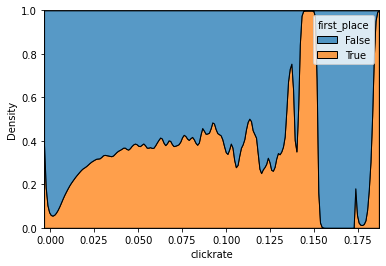

In [16]:
sns.kdeplot(x=packages.clickrate, hue=packages.first_place, multiple="fill")

In [17]:
packages["test_week"] = pd.to_datetime(packages["test_week"])
packages["created_at"] = pd.to_datetime(packages["created_at"])

In [18]:
clicks_over_time = packages.groupby(["test_week"], sort=True)["clicks"].sum()

It seems counterintuitive that the number of clicks per week dropped towards the end of the measure period

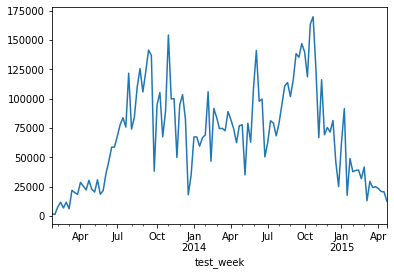

In [19]:
clicks_over_time.plot()

In [20]:
daily_users["date"] = pd.to_datetime(daily_users["date"])
daily_users = daily_users.set_index("date")
daily_pageviews["date"] = pd.to_datetime(daily_pageviews["date"])
daily_pageviews = daily_pageviews.set_index("date")

In [21]:
daily_pageviews['pageviews']

date
2013-01-01      92812
2013-02-01     182645
2013-03-01     286954
2013-04-01     331373
2013-05-01     194671
               ...   
2015-04-26    1014575
2015-04-27    1173595
2015-04-28    1717066
2015-04-29    1790653
2015-04-30    1143420
Name: pageviews, Length: 850, dtype: int64

In [22]:
daily_users.dtypes

users                  int64
new_users              int64
sessions_per_user    float64
sessions             float64
session_duration      object
bounce_rate           object
pageviews            float64
pages_per_session    float64
dtype: object

In [23]:
daily_users['users'].isnull().sum()

0

In [24]:
testpak = packages.groupby(['test_id','image_id']).aggregate({'impressions':'sum','clicks':'sum','first_place':'max','winner':'max', 'test_week':'nunique', 'headline':'nunique', 'slug':'count'})
testpak['clickrate'] = testpak['clicks']/testpak['impressions']
testpak

impressions  ...  clickrate
test_id                  image_id                               ...           
5143605e220cb80002000076 5332b5101fae79f09f00020c        20596  ...   0.013935
51436060220cb800020001df 5332ba641fae79f09f003410         8048  ...   0.008449
                         5332ba641fae79f09f003414         2733  ...   0.006952
51436060220cb800020001e1 5332ba161fae79f09f002c78        10641  ...   0.016070
51436060220cb800020001e3 5332ba141fae79f09f002c4e        10603  ...   0.017919
...                                                        ...  ...        ...
55417382313766001c440000 55417276343635001c550000         2049  ...   0.022450
                         55417276343635002c5e0000         1995  ...   0.011529
                         55417276343635002c5f0000         2067  ...   0.011611
55417f91343635002c7e0000 55417276343635001c550000        12132  ...   0.018958
55418d7b313132002c070000 55417276343635001c550000         6047  ...   0.010584

[71356 rows x 8 columns]

Cause and effect: we must keep all variables fixed and try to understand what was changed and how that provoked a reaction. Why would upworthy do A/B test that only differ by share_text, even though share_text is not shown to the users? How come there are test_ids without a first_place?

We could go for all test_ids that have no difference in image_id and test_week and perform some causal inference if they have a difference in headline. This way we can infere causality, not just correlation. There remain 15605 rows that satisfy these conditions. Note: there are test_ids that don't have a first_place, I suggest we could take the highest clickrate instead. It is to some extend dubious how first_place is exactly defined. There are headlines without images, which is ok for us

Another idea: We could also try to find out if varying the headline has a bigger effect than varying the image. 

In [25]:
testset_id = testpak[testpak.test_week.eq(1) & testpak.headline.gt(1) & testpak.clicks.gt(0) & testpak.headline.eq(testpak.slug)].index.get_level_values(0)
testset_image = testpak[testpak.test_week.eq(1) & testpak.headline.gt(1) & testpak.clicks.gt(0) & testpak.headline.eq(testpak.slug)].index.get_level_values(1)

In [26]:
testpak2 = packages.groupby(['test_id']).aggregate({'impressions':'sum','clicks':'sum','first_place':'max','winner':'max','image_id':'nunique', 'test_week':'nunique', 'headline':'nunique', 'slug':'count'})
testpak2['clickrate'] = testpak2['clicks']/testpak2['impressions']
testpak2

,impressions,clicks,first_place,winner,image_id,test_week,headline,slug,clickrate
test_id,,,,,,,,,
5143605e220cb80002000076,20596,287,True,True,1,1,5,5,0.013935
51436060220cb800020001df,10781,87,False,False,2,1,4,4,0.008070
51436060220cb800020001e1,10641,171,False,False,1,1,4,4,0.016070
51436060220cb800020001e3,10603,190,True,True,1,1,4,4,0.017919
51436061220cb800020001e4,15576,96,True,True,1,1,4,4,0.006163
...,...,...,...,...,...,...,...,...,...
55414d72383063002c6c0000,8157,57,True,True,1,1,1,4,0.006988
55415ee3313766000c200000,12180,60,True,False,6,1,1,6,0.004926
55417382313766001c440000,12153,184,True,False,6,1,1,6,0.015140


In [27]:
testset_id = testpak2[testpak2.test_week.eq(1) & testpak2.headline.gt(1) & testpak2.image_id.lt(2) & testpak2.clicks.gt(0) & testpak2.headline.eq(testpak2.slug)].index

In [28]:
test_dataset = packages.loc[packages.test_id.isin(testset_id)]
test_dataset.to_csv('/content/drive/MyDrive/DataOpen/test_packages_1image.csv')

**Note**: we have to be really careful with the samples, there are multiple doublicates that don't differ at all except for the clicks and impressions e.g. test_id 5143606b220cb800020005db

Those test_ids are excluded from our test sample we use to do inference and prediction on

In [29]:
packages[packages.test_id.eq("5143606b220cb800020005db")]

,created_at,test_week,test_id,headline,image_id,excerpt,lede,slug,share_text,share_image,impressions,clicks,first_place,winner,clickrate,high_ctr_test,high_ctr_test_image
26061,2013-03-12,2013-03-11,5143606b220cb800020005db,Genius Inventor Cracks Secret Of Trees To Harn...,5332ba5c1fae79f09f003372,"Oh, And He’s 13.","<p>Watch out, Big Oil companies. This 13-year-...",genius-inventor-cracks-secret-of-trees-to-harn...,NaN,tree_thumb.jpg,2863,65,False,False,0.022703,False,False
50587,2013-03-12,2013-03-11,5143606b220cb800020005db,Genius Inventor Cracks Secret Of Trees To Harn...,5332ba5c1fae79f09f003372,Could this teenager cause the downfall of big ...,"<p>Watch out, Big Oil companies. This 13-year-...",genius-inventor-cracks-secret-of-trees-to-harn...,NaN,tree_thumb.jpg,2661,59,False,False,0.022172,False,False
50589,2013-03-12,2013-03-11,5143606b220cb800020005db,Genius Inventor Cracks Secret Of Trees To Harn...,5332ba5c1fae79f09f003372,Could this teenager cause the downfall of big ...,"<p>Watch out, Big Oil companies. This 13-year-...",genius-inventor-cracks-secret-of-trees-to-harn...,NaN,tree_thumb.jpg,2823,74,False,True,0.026213,False,False
50590,2013-03-12,2013-03-11,5143606b220cb800020005db,Meet The 13 Year-Old Who's Making Most Scienti...,5332ba5c1fae79f09f003372,Genius inventor cracks secret of trees to harn...,"<p>Watch out, Big Oil companies. This 13-year-...",meet-the-13-year-old-whos-making-most-scientis...,NaN,tree_thumb.jpg,2820,82,True,False,0.029078,True,True


In [30]:
test_dataset = packages.loc[packages.test_id.isin(testset_id)]
test_dataset = test_dataset.loc[test_dataset.image_id.isin(testset_image)]


These are all packages that have at least 2 headlines per image_id within their test_ids, a unique test_week within their test_ids and as many headlines per test_id and image_id combination as packages (so no duplicate headlines). In addition, I deleted the test_ids that didn't havy any clicks at all among all packages. In total there are 16519 unique test_ids and 72135 packages 

In [31]:
test_dataset.head(1)

,created_at,test_week,test_id,headline,image_id,excerpt,lede,slug,share_text,share_image,impressions,clicks,first_place,winner,clickrate,high_ctr_test,high_ctr_test_image
12,2014-11-20,2014-11-17,546e009a9ad54ec65b00004b,What They Learned From The Scientist Was Terri...,546c7f2dbadeb5788700000a,Things that matter. Pass 'em on.,<p>Some decent guys fighting for an important ...,what-they-learned-from-the-scientist-was-terri...,NaN,NaN,4594,51,False,False,0.011101,False,False


Keeping everything relevant for the test stable, we control what contributes towards higher clickrates. This way we can describe causality and not just correlation. This could look something like this, but with the sentiment. Then we can perform 

In [32]:
highest_ctr = packages.loc[packages.test_id.isin(testset_id) & packages.image_id.isin(testset_image) & packages.high_ctr_test.eq(True)]
lower_ctr = packages.loc[packages.test_id.isin(testset_id) & packages.image_id.isin(testset_image) & packages.high_ctr_test.eq(False)]

In [33]:
highest_ctr['winner'].mean()

0.11940094371879915

In [34]:
lower_ctr['winner'].mean()

0.00972304629930905

This is what we could do in a very first step to get some basic hypothesis tested

In [35]:
stats.ttest_ind(highest_ctr.winner, lower_ctr.winner, equal_var=False)

Ttest_indResult(statistic=40.386334063973024, pvalue=0.0)

### Using Test Dataset from here on

In [36]:
data = pd.read_csv("/content/drive/MyDrive/DataOpen/test_packages.csv")

In [37]:
data["test_week"] = pd.to_datetime(data["test_week"])
data["created_at"] = pd.to_datetime(data["created_at"])

In [38]:
data.dtypes

Unnamed: 0                      int64
created_at             datetime64[ns]
test_week              datetime64[ns]
test_id                        object
headline                       object
image_id                       object
excerpt                        object
lede                           object
slug                           object
share_text                     object
share_image                    object
impressions                     int64
clicks                          int64
first_place                      bool
winner                           bool
clickrate                     float64
high_ctr_test                    bool
high_ctr_test_image              bool
dtype: object

As an example let's take a look at the developement of tests per week over the observed time

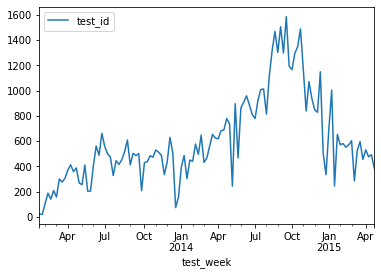

In [39]:
tests_per_week = data.groupby('test_week').aggregate({'test_id':'count'})
tests_per_week.plot()

Autocorrelation and partial autocorrelation plots of the tests per week over the observed time

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


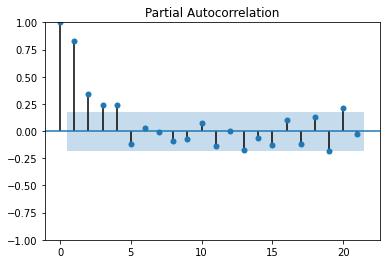

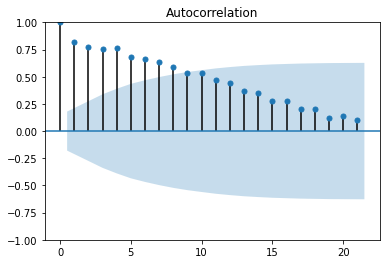

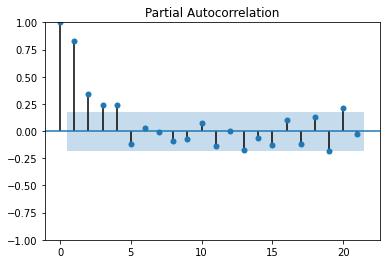

In [40]:
plot_acf(tests_per_week)
plot_pacf(tests_per_week)

The distribution of the clickrates over all test_ids can well be approximated by a lognormal distribution

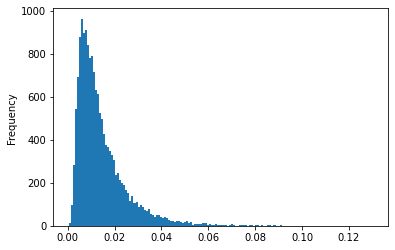

In [41]:
tests = data.groupby('test_id').aggregate({'impressions':'sum','clicks':'sum'})
tests['clickrate'] = tests['clicks']/tests['impressions']
tests.clickrate.plot.hist(bins=150)

If we take the log of the clickrate we get a distribution that is very close to a normal distribution

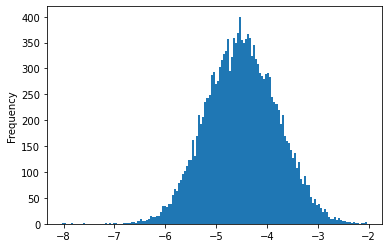

In [42]:
np.log(tests.clickrate).plot.hist(bins=150)

In [43]:
daily_pageviews['pageviews'] = daily_pageviews['pageviews'].astype(str)

In [44]:
daily_pageviews['pageviews']

date
2013-01-01      92812
2013-02-01     182645
2013-03-01     286954
2013-04-01     331373
2013-05-01     194671
               ...   
2015-04-26    1014575
2015-04-27    1173595
2015-04-28    1717066
2015-04-29    1790653
2015-04-30    1143420
Name: pageviews, Length: 850, dtype: object

Here we see how the clickrate developed over time

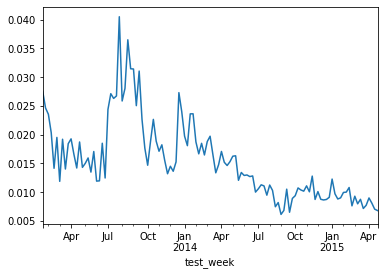

In [45]:
clickrate_over_time = data.groupby(['test_week']).aggregate({'clicks':'sum','impressions':'sum'})
clickrate_over_time['clickrate'] = clickrate_over_time['clicks']/clickrate_over_time['impressions']
clickrate_over_time['clickrate'].plot()

In [46]:
adfuller(clickrate_over_time.clickrate)

(-1.8184337536065656,
 0.37134900971442064,
 2,
 116,
 {'1%': -3.4880216384691867,
  '10%': -2.5802408234244947,
  '5%': -2.8867966864160075},
 -888.5217673438715)

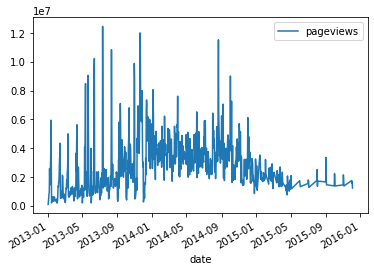

In [47]:
daily_pageviews = daily_pageviews.astype(str).astype(int)
daily_pageviews.plot()

In [48]:
daily_users = daily_users.astype({'users':'int64','new_users':'int64','sessions':'int64','pageviews':'int64'}, errors='ignore')
daily_users

,users,new_users,sessions_per_user,sessions,session_duration,bounce_rate,pageviews,pages_per_session
date,,,,,,,,
2013-01-01,67283,17706,1.05,68825.0,00:01:46,80.00%,82590.0,1.15
2013-02-01,123942,53118,1.03,NaN,00:01:25,72.22%,NaN,1.44
2013-03-01,194766,88530,1.13,NaN,00:01:05,77.42%,NaN,1.31
2013-04-01,237261,123942,1.09,NaN,00:02:09,87.67%,NaN,1.15
2013-05-01,134566,60200,1.13,NaN,00:01:35,76.74%,NaN,1.26
...,...,...,...,...,...,...,...,...
2015-04-26,779065,371826,1.09,850679.0,00:00:41,90.42%,1026871.0,1.25
2015-04-27,878218,322249,1.09,958046.0,00:01:27,84.44%,1227841.0,1.27
2015-04-28,1327951,644499,1.07,1428810.0,00:00:54,88.34%,1720629.0,1.15


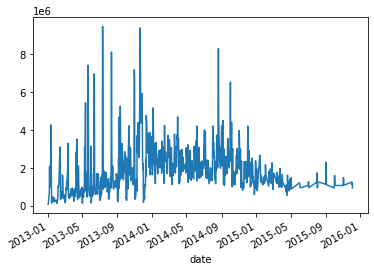

In [49]:
daily_users.users.plot()

## Time Series Analysis

In [50]:
from statsmodels.tsa.arima.model import ARIMA

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import statistics
import statsmodels.tsa.stattools as tsa
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from scipy.stats import shapiro
import seaborn as sns

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

In [52]:
import pmdarima as pm

### Sentiment change over time

In [53]:
test_packages = pd.read_csv('/content/drive/MyDrive/DataOpen/test_packages_with_sentiment.csv')

In [54]:
test_packages["test_week"] = pd.to_datetime(test_packages["test_week"])
test_packages["created_at"] = pd.to_datetime(test_packages["created_at"])

In [55]:
test_packages.head(1)

,Unnamed: 0,Unnamed: 0.1,created_at,test_week,test_id,headline,image_id,excerpt,lede,slug,share_text,share_image,impressions,clicks,first_place,winner,clickrate,high_ctr_test,high_ctr_test_image,neg,neu,pos
0,0,12,2014-11-20,2014-11-17,546e009a9ad54ec65b00004b,What They Learned From The Scientist Was Terri...,546c7f2dbadeb5788700000a,Things that matter. Pass 'em on.,<p>Some decent guys fighting for an important ...,what-they-learned-from-the-scientist-was-terri...,NaN,NaN,4594,51,False,False,0.011101,False,False,0.012229,0.839929,0.147842


We want to find out what sentiment was the strongest in each of the packages, thus we define 3 new columns: max_neg, max_neu and max_pos that are boolean and indicate wheter the respective sentiment was the most pronounced.

In [56]:
test_packages['max_neg'] = test_packages[['neg','neu','pos']].max(axis=1) == test_packages['neg']
test_packages['max_neu'] = test_packages[['neg','neu','pos']].max(axis=1) == test_packages['neu']
test_packages['max_pos'] = test_packages[['neg','neu','pos']].max(axis=1) == test_packages['pos']

We also want to know what the most pronounced sentiment in the most clicked package was. Here we (still) define the tests different than in the original data set, as we keep the week and image_id constant, but do not need to keep the specific test_id constant, as we have distinct headlines and can thus already reason about causality. The newly created boolean colomns neg_high, neu_high, pos_high thus indicate whether a respective package was the most clicked within their test and wheterh the most pronounced senteiment was negative, neutral or positive, respectively. 

In [57]:
test_packages['neg_high'] = test_packages.max_neg.eq(True) & test_packages.high_ctr_test_image.eq(True)
test_packages['neu_high'] = test_packages.max_neu.eq(True) & test_packages.high_ctr_test_image.eq(True)
test_packages['pos_high'] = test_packages.max_pos.eq(True) & test_packages.high_ctr_test_image.eq(True)

Most of the time, negative sentiment dominates among the 3 sentiment levels

In [58]:
test_packages[['neg_high','neu_high','pos_high']].sum()

neg_high    7228
neu_high    6545
pos_high    2677
dtype: int64

In [59]:
weekly = test_packages.groupby('test_week').aggregate({'test_id':'count', 'impressions':'sum', 'clicks':'sum', 'max_neg':'sum', 'max_neu':'sum','max_pos':'sum', 'neg_high':'sum', 'neu_high':'sum', 'pos_high':'sum'})
weekly['clickrate'] = weekly['clicks']/weekly['impressions']

We want to know what was the weekly percentage of mostly negative, neutral or positive sentiment, respectivley. This way the results can be compared to the number of most clicked packages from each of these 3 sentiment categories.

In [60]:
weekly['pneg'] = weekly.max_neg/weekly.test_id
weekly['pneu'] = weekly.max_neu/weekly.test_id
weekly['ppos'] = weekly.max_pos/weekly.test_id

In [61]:
total_weekly_high = weekly.neg_high + weekly.neu_high + weekly.pos_high
weekly['pneg_high'] = weekly.neg_high/total_weekly_high
weekly['pneu_high'] = weekly.neu_high/total_weekly_high
weekly['ppos_high'] = weekly.pos_high/total_weekly_high

In [62]:
weekly.head()

,test_id,impressions,clicks,max_neg,max_neu,max_pos,neg_high,neu_high,pos_high,clickrate,pneg,pneu,ppos,pneg_high,pneu_high,ppos_high
test_week,,,,,,,,,,,,,,,,
2013-01-21,22,42335,1165,17,3,2,6,0,1,0.027519,0.772727,0.136364,0.090909,0.857143,0.000000,0.142857
2013-01-28,19,46655,1150,5,9,5,2,2,1,0.024649,0.263158,0.473684,0.263158,0.400000,0.400000,0.200000
2013-02-04,106,302866,7134,49,45,12,16,9,6,0.023555,0.462264,0.424528,0.113208,0.516129,0.290323,0.193548
2013-02-11,187,515211,10492,80,76,31,24,19,12,0.020364,0.427807,0.406417,0.165775,0.436364,0.345455,0.218182
2013-02-18,140,424712,6011,43,62,35,16,17,12,0.014153,0.307143,0.442857,0.250000,0.355556,0.377778,0.266667


Developement of percentage of negative, neutral and positive sentiment most clicked in tested packages per week

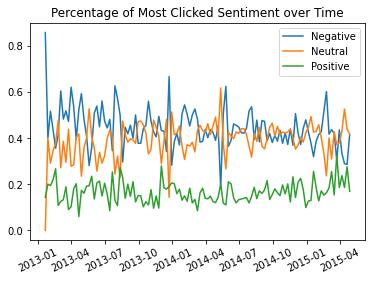

In [63]:
plt.figure()
plt.plot(weekly.pneg_high, label='Negative')
plt.plot(weekly.pneu_high, label='Neutral')
plt.plot(weekly.ppos_high, label='Positive')
plt.title('Percentage of Most Clicked Sentiment over Time')
plt.xticks(rotation=25)
plt.legend()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


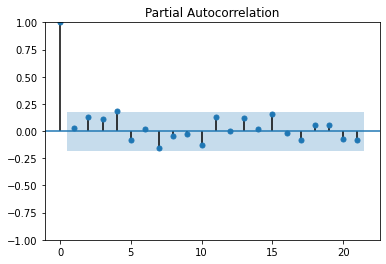

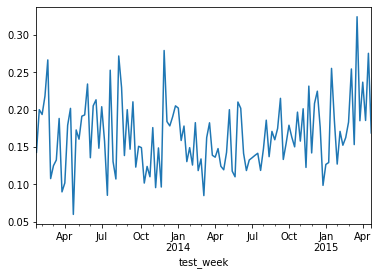

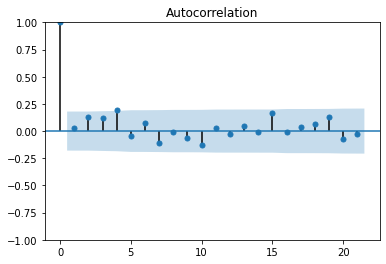

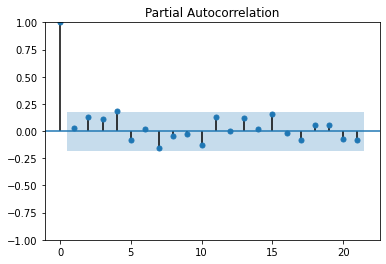

In [64]:
# Visualising the differenced series
weekly.ppos_high.plot()
tsaplots.plot_acf(weekly.ppos_high, alpha=0.05)
tsaplots.plot_pacf(weekly.ppos_high, alpha=0.05)


Sample inference for percentage of packages per week with positive sentiment. The negative and neutral sentiment time series are both constant and the best fitted ARIMA models are ARIMA(0,0,0), so a constant, for both. This in turn, indicates stable percentage of sentiment over time.  

In [65]:
result = adfuller(weekly.pneg_high)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -10.983014
p-value: 0.000000


Clearly the three time serieses are stationary and constant with only little variation

In [66]:
model = pm.auto_arima(weekly.ppos_high, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic


/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-379.933, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-79.108, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-309.646, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-164.236, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-378.384, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-378.322, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-214.451, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-347.745, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-375.933, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-385.307, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-384.817, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-384.839, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-385.424, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-384.878, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-384.129, Time=0.35 sec
 ARIMA(2,0,

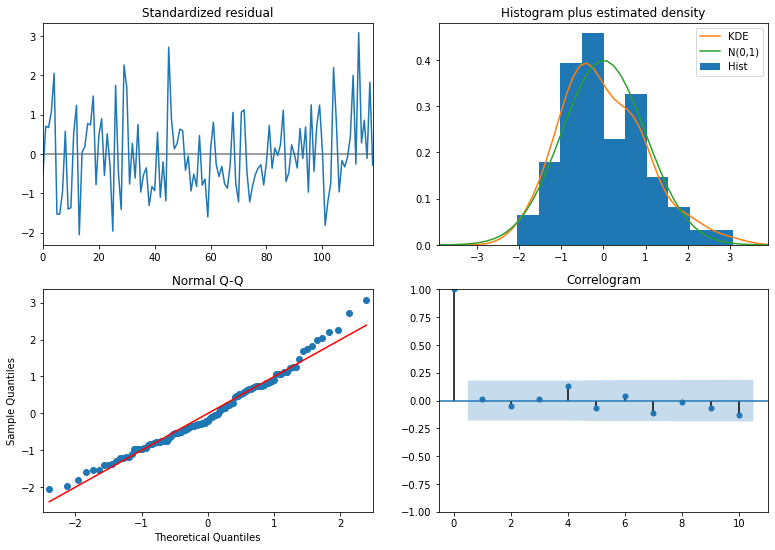

In [67]:
model.plot_diagnostics(figsize=(13,9))
plt.show()

### Time series Clickrate

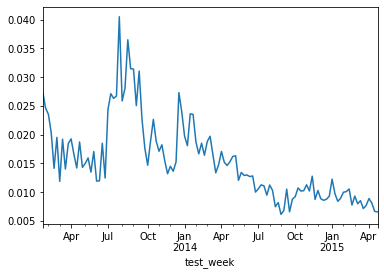

In [68]:
weekly.clickrate.plot()

In [69]:
train = weekly.clickrate[0:100]
test = weekly.clickrate[100:]

In [70]:
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.803982
p-value: 0.378487


The ARIMA(0,1,1) models seems to be the best fit to describe this time series

In [71]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-814.263, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-799.773, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-813.313, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-816.332, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-801.565, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-814.883, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-813.272, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-817.404, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-815.529, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-815.369, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-814.891, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-813.484, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.329 seconds
                               SARIMAX Results                                
Dep. Vari

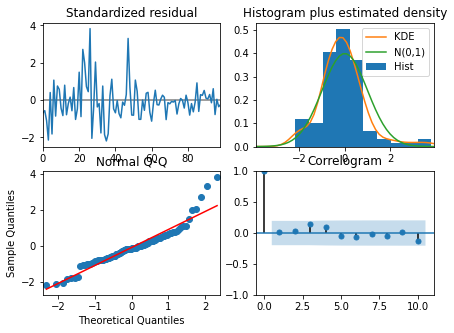

In [72]:
model.plot_diagnostics(figsize=(7,5))
plt.show()